# Import needed libraries
To make things work ensure that you have this libraries installed.

In [2]:
import os
import numpy as np
import splitfolders
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2

# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [3]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
            
        self.__generate()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        self.train_len = len(train_paths)
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        self.val_len = len(val_paths)
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        self.test_len = len(test_paths)
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [4]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# STFT

In [5]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.train, dataset.val, dataset.test

Copying files: 4995 files [00:11, 447.69 files/s]


In [6]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer = l1(0.05))(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

num_classes = 10

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 5

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1,
                    callbacks = [early_stopping])

model.summary()


Epoch 1/5
   1/3496 ━━━━━━━━━━━━━━━━━━━━ 28:29:36 29s/step - accuracy: 0.0000e+00 - loss: 17.4613

I0000 00:00:1712692305.360227    2400 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712692305.410929    2400 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3496/3496 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8304 - loss: 2.2328

W0000 00:00:1712692731.549863    2400 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712692735.581356    2401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3496/3496 ━━━━━━━━━━━━━━━━━━━━ 488s 131ms/step - accuracy: 0.8305 - loss: 2.2324 - val_accuracy: 0.6530 - val_loss: 1.4096
Epoch 2/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 442s 126ms/step - accuracy: 0.9978 - loss: 0.2441 - val_accuracy: 0.6994 - val_loss: 1.1509
Epoch 3/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 439s 126ms/step - accuracy: 0.9991 - loss: 0.1751 - val_accuracy: 0.7919 - val_loss: 0.8695
Epoch 4/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 437s 125ms/step - accuracy: 0.9996 - loss: 0.1462 - val_accuracy: 0.9346 - val_loss: 0.3513
Epoch 5/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 437s 125ms/step - accuracy: 0.9924 - loss: 0.1522 - val_accuracy: 0.9333 - val_loss: 0.3286


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ activation_2[0][… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_4[0][

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

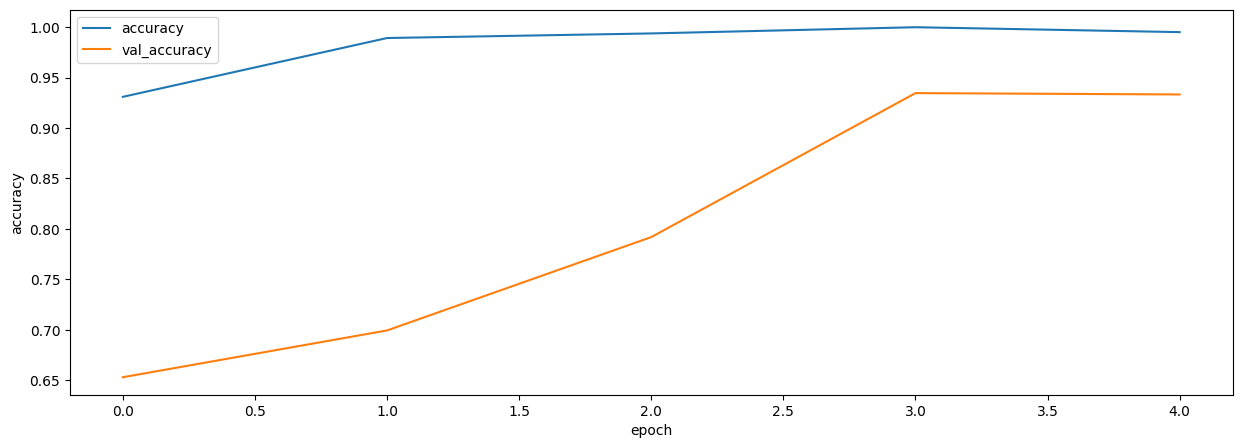

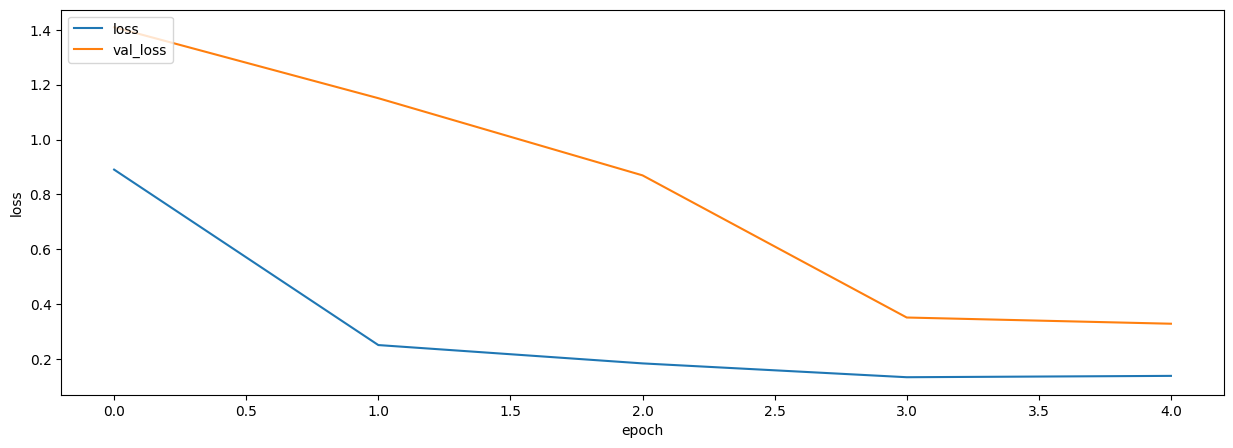

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9237 - loss: 0.3531
Accuracy: 0.9346666932106018
Loss: 0.3327800929546356
 5/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

W0000 00:00:1712694730.806017    2400 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


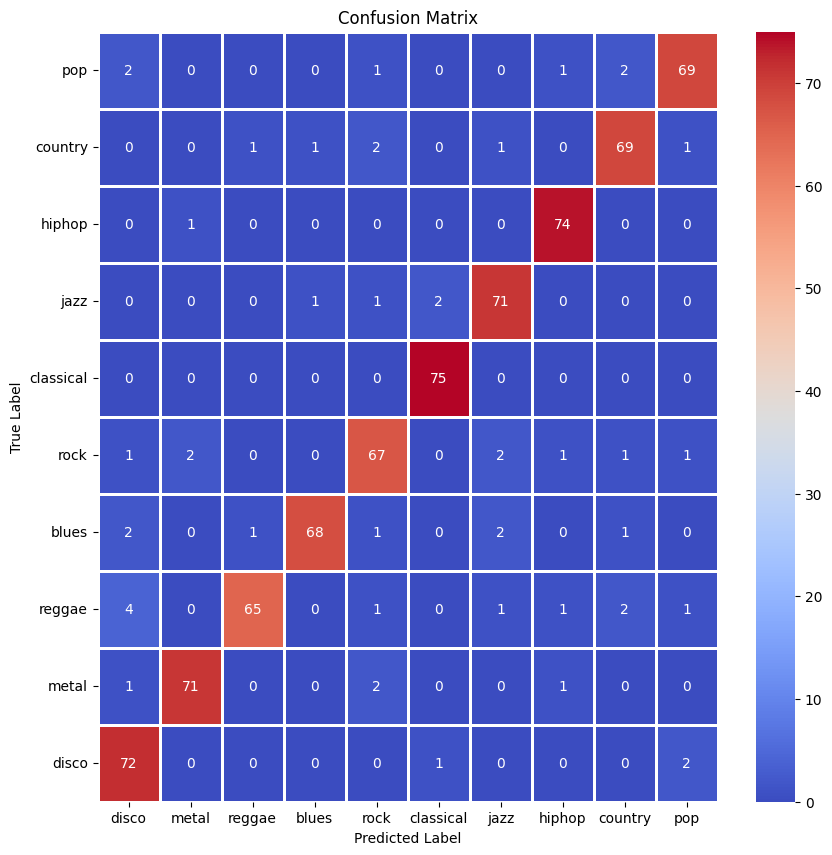

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        75
           1       0.96      0.95      0.95        75
           2       0.97      0.87      0.92        75
           3       0.97      0.91      0.94        75
           4       0.89      0.89      0.89        75
           5       0.96      1.00      0.98        75
           6       0.92      0.95      0.93        75
           7       0.95      0.99      0.97        75
           8       0.92      0.92      0.92        75
           9       0.93      0.92      0.93        75

    accuracy                           0.93       750
   macro avg       0.94      0.93      0.93       750
weighted avg       0.94      0.93      0.93       750



In [7]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel - Spectrogram

In [8]:
batch_size = 16
dataset_mel = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)
train_mel, val_mel, test_mel = dataset_mel.train, dataset_mel.val, dataset_mel.test

Copying files: 4995 files [00:11, 434.95 files/s]


In [9]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax',  kernel_regularizer = l1(0.05))(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

num_classes = 10  

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 5

history = model.fit(dataset_mel.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset_mel.train_len,
                    validation_data=dataset_mel.val,
                    validation_steps=dataset_mel.val_len,
                    verbose=1,
                    callbacks = [early_stopping])

model.summary()


Epoch 1/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6110 - loss: 3.0171

W0000 00:00:1712695101.355011    2401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3496/3496 ━━━━━━━━━━━━━━━━━━━━ 287s 75ms/step - accuracy: 0.6110 - loss: 3.0166 - val_accuracy: 0.6132 - val_loss: 1.7497
Epoch 2/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 249s 71ms/step - accuracy: 0.9800 - loss: 0.4784 - val_accuracy: 0.8809 - val_loss: 0.6463
Epoch 3/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 248s 71ms/step - accuracy: 0.9962 - loss: 0.2476 - val_accuracy: 0.8531 - val_loss: 0.6967
Epoch 4/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 248s 71ms/step - accuracy: 0.9996 - loss: 0.1917 - val_accuracy: 0.8919 - val_loss: 0.5010
Epoch 5/5
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 248s 71ms/step - accuracy: 0.9794 - loss: 0.2336 - val_accuracy: 0.8890 - val_loss: 0.5124


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_28[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_29[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 56, 56,    │          0 │ activation_30[0]… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 56, 56,    │          0 │ add_8[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_31[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_32[0]

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

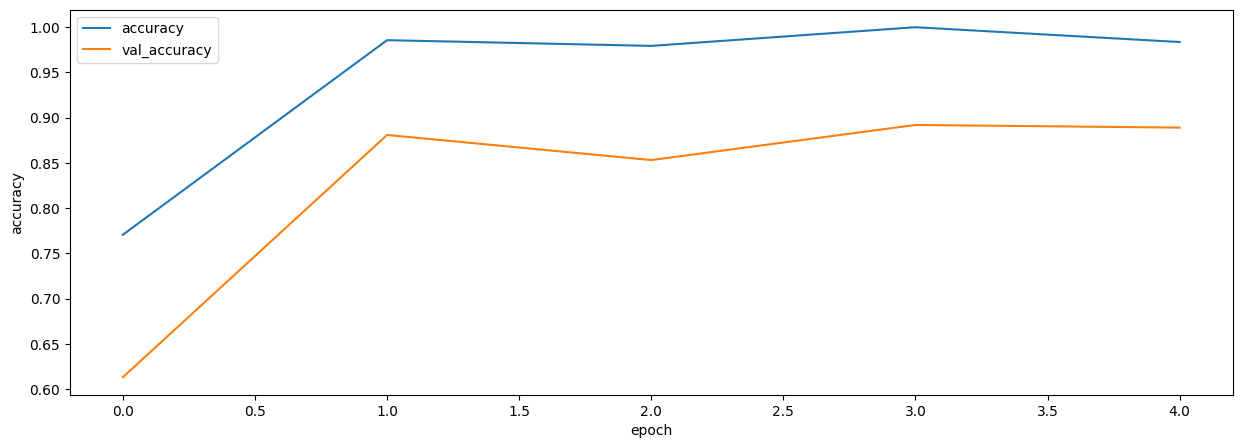

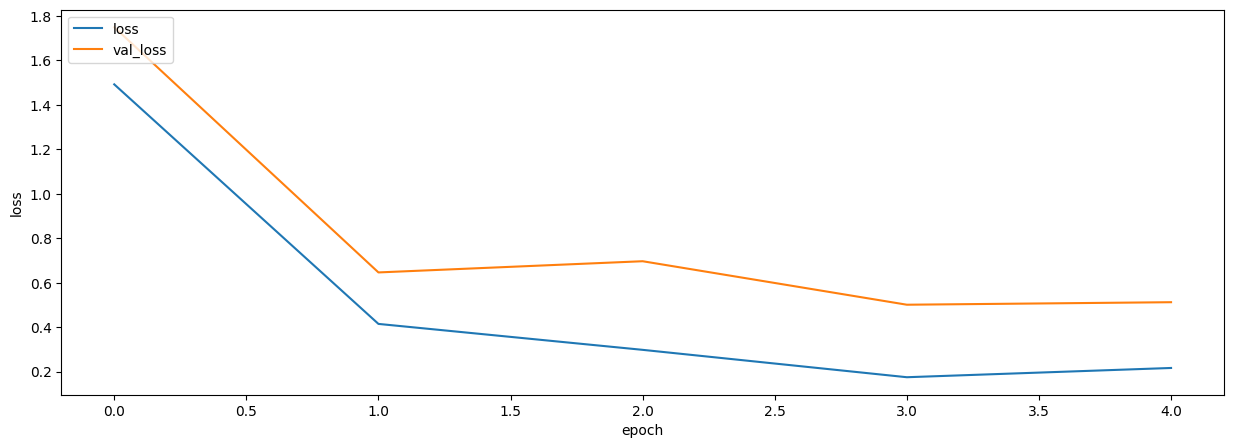

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9194 - loss: 0.4158
Accuracy: 0.9253333210945129
Loss: 0.41542476415634155
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


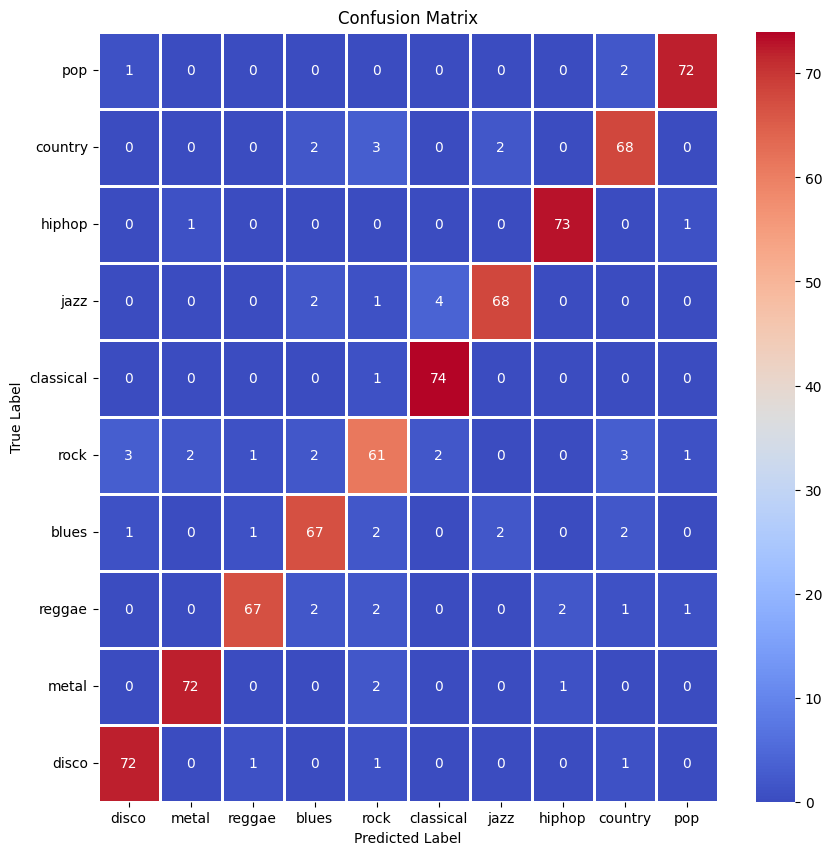

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        75
           1       0.96      0.96      0.96        75
           2       0.96      0.89      0.92        75
           3       0.89      0.89      0.89        75
           4       0.84      0.81      0.82        75
           5       0.93      0.99      0.95        75
           6       0.94      0.91      0.93        75
           7       0.96      0.97      0.97        75
           8       0.88      0.91      0.89        75
           9       0.96      0.96      0.96        75

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



In [10]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_mel, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_mel)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_mel], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))